# Transmission chain simulation

This notebook runs a simple synthetic transmission chain over block-building programs.
We track how program length and a simple sequence-accuracy score change over generations under noise and compression biases.


In [8]:
import os
import sys
import random
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


NUM_GENERATIONS = 20
NUM_CHAINS = 20
SEED = 42

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)

# Make project root importable so we can access the transmission chain model
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from model.transmission.transmission_chain import (
    MANUAL_TOWER_PROGRAMS,
    TransmissionChain,
    DEFAULT_DSL,
    expanded_length,
    sequence_accuracy,
    expand_program,
    visual_overlap_score,
)


In [9]:
# Import block renderer for visual comparison of towers
BLOCK_UTILS_DIR = os.path.join(ROOT_DIR, "model", "block_utils")
if BLOCK_UTILS_DIR not in sys.path:
    sys.path.append(BLOCK_UTILS_DIR)
from block_utils import render_program  # type: ignore[import]

In [10]:
def program_to_tokens(s: str) -> List[str]:
    return s.split()


def tokens_to_program(tokens: List[str]) -> str:
    return " ".join(tokens)


print("Available example programs:")
for name, prog in MANUAL_TOWER_PROGRAMS.items():
    print(f"{name}: {prog}")

Available example programs:
CL: h l_1 v v r_1 h r_12 h l_4 h l_1 v v
CPi: h l_1 v v r_1 h r_6 v r_6 v l_5 h r_4 h
PiC: v r_6 v l_5 h r_4 h r_7 h l_1 v v r_1 h
LPi: h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h
LC: h l_4 h l_1 v v r_12 h l_1 v v r_1 h
PiL: v r_6 v l_5 h r_4 h r_9 h l_4 h l_1 v v


In [11]:
# Choose a tower program to use as the true target
TRUE_SCENE_KEY = "CL"
true_program_str = MANUAL_TOWER_PROGRAMS[TRUE_SCENE_KEY]
true_tokens = program_to_tokens(true_program_str)

print("\nTrue program (scene key = {}):".format(TRUE_SCENE_KEY))
print(true_program_str)
print("Tokenized true program:", true_tokens)

# Initialize a transmission chain model with default parameters
single_chain_model = TransmissionChain(dsl=DEFAULT_DSL)

# Run the chain for a fixed number of generations
programs_over_time = single_chain_model.run_chain(true_tokens, num_generations=NUM_GENERATIONS)

# Collect basic summary statistics for each generation
rows_single = []
for gen_idx, prog_tokens in enumerate(programs_over_time):
    prog_text = tokens_to_program(prog_tokens)
    length_expanded = expanded_length(prog_tokens)
    acc = sequence_accuracy(true_tokens, prog_tokens)
    vis = visual_overlap_score(true_tokens, prog_tokens)
    rows_single.append(
        {
            "generation": gen_idx,
            "program_text": prog_text,
            "length_expanded": length_expanded,
            "accuracy": acc,
            "visual_overlap": vis,
        }
    )

results_df = pd.DataFrame(rows_single)
print("\nSingle-chain summary (first few rows):")
print(results_df.head())
print("\nSingle-chain final generations:")
print(results_df.tail())



True program (scene key = CL):
h l_1 v v r_1 h r_12 h l_4 h l_1 v v
Tokenized true program: ['h', 'l_1', 'v', 'v', 'r_1', 'h', 'r_12', 'h', 'l_4', 'h', 'l_1', 'v', 'v']

Single-chain summary (first few rows):
   generation                                    program_text  \
0           0            h l_1 v v r_1 h r_12 h l_4 h l_1 v v   
1           1        r_9 r_6 l_1 v r_1 h r_12 h l_4 h l_1 v*2   
2           2            r_9 v r_1 h r_12 h r_1 l_4 h l_1 v*2   
3           3  r_9 r_7 v r_1 h r_4 r_12 h r_1 l_4 l_1 l_1 v*2   
4           4  r_9 v r_1 h r_4 r_12 v r_1 l_4 l_1*2 l_5 v l_1   

   length_expanded  accuracy  visual_overlap  
0               13  1.000000        1.000000  
1               13  0.769231        0.750000  
2               12  0.153846        0.857143  
3               14  0.384615        0.666667  
4               14  0.230769        0.666667  

Single-chain final generations:
    generation                                     program_text  \
16          16   

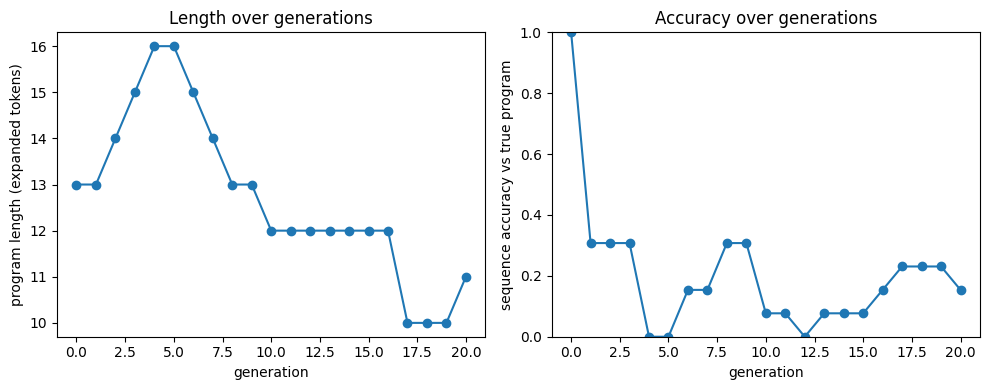

In [5]:
# Plot length and accuracy over generations
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(results_df["generation"], results_df["length_expanded"], marker="o")
axes[0].set_xlabel("generation")
axes[0].set_ylabel("program length (expanded tokens)")
axes[0].set_title("Length over generations")

axes[1].plot(results_df["generation"], results_df["accuracy"], marker="o")
axes[1].set_xlabel("generation")
axes[1].set_ylabel("sequence accuracy vs true program")
axes[1].set_ylim(0.0, 1.0)
axes[1].set_title("Accuracy over generations")

plt.tight_layout()
plt.show()


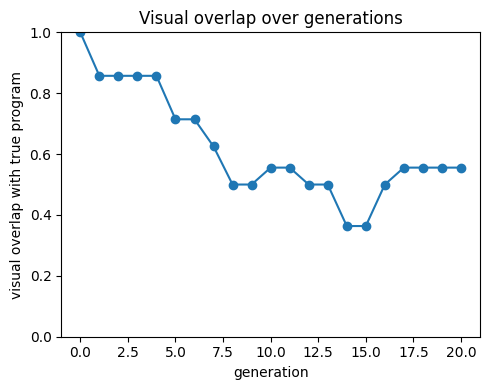

In [6]:
# Plot visual overlap over generations
plt.figure(figsize=(5, 4))
plt.plot(results_df["generation"], results_df["visual_overlap"], marker="o")
plt.xlabel("generation")
plt.ylabel("visual overlap with true program")
plt.ylim(0.0, 1.0)
plt.title("Visual overlap over generations")
plt.tight_layout()
plt.show()


Rendering generation 0 (sequence accuracy = 1.000):
h l_1 v v r_1 h r_12 h l_4 h l_1 v v


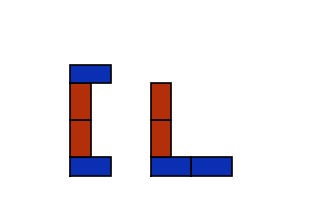


Rendering generation 10 (sequence accuracy = 0.077):
v r_1 r_4 v v r_1 r_7 l_4 h l_1 v l_5


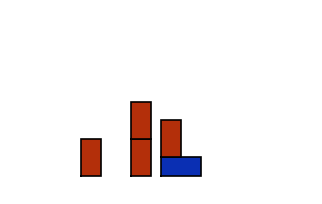


Rendering generation 20 (sequence accuracy = 0.154):
h r_9 r_1 v v r_4 l_1 r_9 v l_5 l_4
Rendering skipped: program moves blocks outside the valid range.


In [7]:
# Render a few generations to visually inspect tower differences
selected_generations = [0, NUM_GENERATIONS // 2, NUM_GENERATIONS]
for g in selected_generations:
    prog_tokens = programs_over_time[g]
    # Expand any macros like "v*2" before rendering
    expanded_tokens = expand_program(prog_tokens)
    prog_str_for_render = tokens_to_program(expanded_tokens)
    acc_g = float(results_df.loc[results_df["generation"] == g, "accuracy"].iloc[0])
    print(f"\nRendering generation {g} (sequence accuracy = {acc_g:.3f}):")
    print(prog_str_for_render)
    try:
        render_program(prog_str_for_render)
    except AssertionError:
        print("Rendering skipped: program moves blocks outside the valid range.")
    except Exception as e:
        print(f"Rendering skipped due to error: {e}")

In [12]:
# Run many independent chains to explore complexity–accuracy trade-off
all_rows = []
for chain_id in range(NUM_CHAINS):
    chain_model = TransmissionChain(dsl=DEFAULT_DSL, random_seed=SEED + chain_id)
    progs = chain_model.run_chain(true_tokens, num_generations=NUM_GENERATIONS)
    for gen_idx, prog_tokens in enumerate(progs):
        length_expanded = expanded_length(prog_tokens)
        acc = sequence_accuracy(true_tokens, prog_tokens)
        all_rows.append(
            {
                "chain": chain_id,
                "generation": gen_idx,
                "length_expanded": length_expanded,
                "accuracy": acc,
            }
        )

multi_df = pd.DataFrame(all_rows)
print("\nMulti-chain summary (first few rows):")
print(multi_df.head())



Multi-chain summary (first few rows):
   chain  generation  length_expanded  accuracy
0      0           0               13  1.000000
1      0           1               16  0.307692
2      0           2               16  0.307692
3      0           3               17  0.153846
4      0           4               17  0.153846


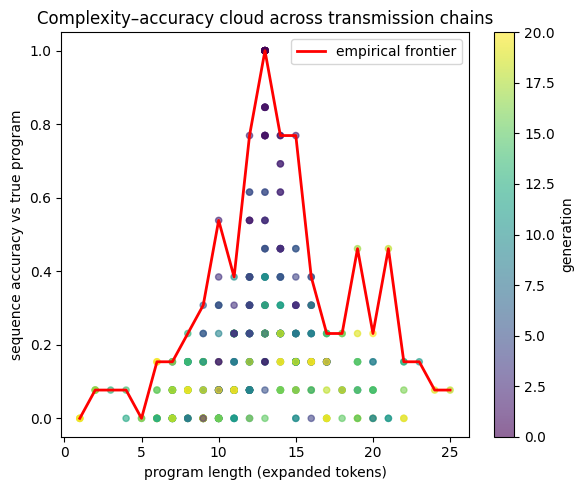

In [ ]:
# Scatter of complexity vs accuracy across chains (IB-style view)
plt.figure(figsize=(6, 5))
sc = plt.scatter(
    multi_df["length_expanded"],
    multi_df["accuracy"],
    c=multi_df["generation"],
    cmap="viridis",
    alpha=0.6,
    s=20,
)
plt.colorbar(sc, label="generation")
plt.xlabel("program length (expanded tokens)")
plt.ylabel("sequence accuracy vs true program")
plt.title("Complexity-accuracy cloud across transmission chains")

# Empirical efficiency frontier: best accuracy at each length
frontier = (
    multi_df.groupby("length_expanded")["accuracy"]
    .max()
    .reset_index()
    .sort_values("length_expanded")
)
plt.plot(
    frontier["length_expanded"],
    frontier["accuracy"],
    color="red",
    linewidth=2,
    label="empirical frontier",
)
plt.legend()
plt.tight_layout()
plt.show()
